In [ ]:
#!AHOCORASICK_BYTES=1 pip install git+https://github.com/WojciechMula/pyahocorasick.git

In [ ]:
import time
import json
import torch
import threading
import numpy as np
from tqdm import tqdm
from collections import deque
from make_model import make_model
from matplotlib import pyplot as plt
from tokenizer import tokenizer,token2str,vocab_size
from train_and_use import SFTBatch,CrossEntropyLoss,SimpleMoOptimizer,OptimizerWrapper,train_server_start
from train_and_use import text_continue
from train_and_use import TOGGLE,STOP,SET_CACULATE_SIZE
from train_and_use import record
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
%matplotlib inline

In [ ]:
#数据格式检查
a_skip_len = len(tokenizer(f"<|im_start|>assistant ",5.0))
def get_batch(chatml_json_item):
    inputs = []
    labels = []
    for item in chatml_json_item['conversations']:
        if item['role'] == 'user':
            u_tokens = tokenizer(f"<|im_start|>{item['role']} {item['content']}<|im_end|>")
            inputs += u_tokens
            labels += [-255]*len(u_tokens)
        else:
            a_tokens = tokenizer(f"<|im_start|>{item['role']} {item['content']}<|im_end|>")
            inputs += a_tokens
            labels += [-255]*a_skip_len + a_tokens[a_skip_len:]
    return inputs[:-1],labels[1:]

In [ ]:
model = make_model(
    #token是从1开始的，0填充，剩下的用来覆盖全部字节
    vocab_size = vocab_size+1+255,
    embedding_dim = 768,
    key_dim = 128,
    head_number = 12,
    position_information_type = "mask",
    enable_affine = True,
    enable_talking_head = True,
    use_diff = False,
    self_attention_block_size = 0,
    feed_forward_dim = 1536,
    enable_layer_norm = True,
    deep = 12,
    dropout_rate = 0.1
).to(device)
parameters_n = 0
for p in model.parameters():
    parameters_n += p.data.cpu().numpy().size
print("模型参数量:"+str(parameters_n/1e9)[:4]+"(B)")

In [ ]:
#改完参数需要检查，否则优化器可能匹配错
def get_info(p_cnt,p):
    if p_cnt==0 or p.dim()==1:
        ret = 'vector'
    elif (p_cnt-1)%25 in [2,3,4] and p_cnt < 25*12:
        ret = 12,128,768
    elif p.dim()==2:
        ret = 'matrix'
    return ret
# #检查对应关系是否正确
# for i,p in enumerate(model.parameters()):
#     print(i,p.size(),get_info(i,p))

In [ ]:
batch_size_adjust = 0
seq_len = 512
total_lines = 4752539
skip = 0
cnt = 0
buffer = deque()
#源源不断的产生分好词的数据
def auto_tokenizer():
    global buffer
    global cnt
    #从文件中流式获取数据
    with open("ChatML_zh_large.jsonl",'r') as f:
        for line in f:
            chatml_json_item = json.loads(line)
            #跳过历史数据
            if cnt < skip:
                cnt += 1
                continue
            #获取新数据
            inputs,labels = get_batch(chatml_json_item)
            #对数据进行过滤
            if len(inputs) > 192 and len(inputs) < 512:
                #进行样本填充
                inputs += [-255]*(seq_len-len(inputs))
                labels += [-255]*(seq_len-len(labels))
                buffer.append([inputs,labels])
                cnt += 1
                #获取数据的数据更快，数据充足时休眠，节约内存
                while len(buffer) > 1024:
                    time.sleep(1)

process_str = ""
#将分好词的数据自合成训练的批次
def data_generator(batch_size):
    global buffer
    global batch_size_adjust
    global process_str
    thread = threading.Thread(target=auto_tokenizer)
    thread.start()
    while len(buffer) == 0:
        time.sleep(1)
    stop = batch_size+batch_size_adjust
    data = []
    while len(buffer):
        data += [buffer.popleft()]
        # 累积到了批次输出样本
        if len(data)==stop:#一个批次产出一次
            # 随时更新批次调整
            stop = batch_size+batch_size_adjust
            trunk = np.array(data)+255
            inputs = torch.from_numpy(trunk[:,0]).to(device).data
            labels = torch.from_numpy(trunk[:,1]).to(device).data
            data = []
            process_str = '{:.4f}'.format(cnt*100/total_lines)+'%'
            yield SFTBatch(inputs,labels)

In [ ]:
model.load_state_dict(torch.load('large_model_13033051.weight',weights_only=True))
model.train()
loss_f = CrossEntropyLoss()
optimizer = OptimizerWrapper(
    optimizer = SimpleMoOptimizer(model.parameters(),betas = (0.9,0.98),eps = 1e-7,weight_decay=0.1,get_info=get_info),
    warm_up = 1024,
    lr = 1e-5,
    enable_wave = False
)
batch_size = 128
caculate_size = 8
train_server_start(model,(data_generator,batch_size),caculate_size,loss_f,optimizer,use_amp = False)

In [ ]:
TOGGLE()
# STOP()

In [389]:
print(process_str)

33.6493%
epoch: 0 	step: 12526 	loss: 2.415 	speed: 5444.69 tokens/s                    

In [ ]:
# optimizer.set_lrate(3e-6,8192)
# optimizer.enable_wave = False

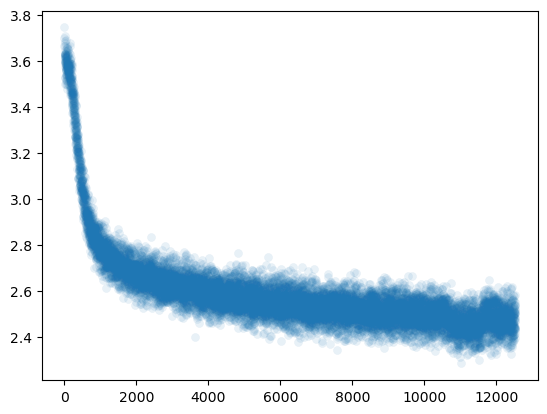

epoch: 0 	step: 12527 	loss: 2.486 	speed: 5114.87 tokens/s                    

In [390]:
plt.close()
plt.scatter(list(range(len(record['loss_line']))),record['loss_line'],alpha=0.1,linewidths=0.1)
# plt.yscale('log')
# plt.plot(record['loss_line'])
plt.show()

In [ ]:
plt.close()
# plt.plot(record['loss_line'])
plt.plot(record['lr_line'])
plt.show()

In [ ]:
%%time
tokens_batch = [tokenizer("<|im_start|>user 请介绍一下苏轼<|im_end|><|im_start|>assistant ",5.0)]
tokens_batch = np.array(tokens_batch,dtype=np.int64)+255
inputs = torch.from_numpy(tokens_batch).to(device).data
model = model.eval()
with torch.no_grad():
    o = text_continue(
        model,inputs,out_length=64,
        repeat_penalty_value = 2.5,
        temperature = 0.01,
        decay = 0.98
    )
print(token2str(o[0].cpu().numpy()-255))
model = model.train()

In [ ]:
# torch.save(model.state_dict(),'large_model_instruct_11631.weight')

In [ ]:
# #用于注入自身身份信息（该单元格是阻塞的，请选对时机，注入前，需要在别处确保inputs的长度等于seq_len）
# #由于使用的分词算法有随机性，所以要确保长度有冗余，避免溢出造成崩溃。
# for i in range(100):
#     with open("self.jsonl",'r') as f:
#         chatml_json_items = []
#         for line in f:
#             chatml_json_items += [json.loads(line)]
#         np.random.shuffle(chatml_json_items)
#         for chatml_json_item in chatml_json_items:
#             inputs,labels = get_batch(chatml_json_item)
#             inputs += [-255]*(seq_len-len(inputs))
#             labels += [-255]*(seq_len-len(labels))
#             buffer.append([inputs,labels])
#             time.sleep(5)
#             print(i)